In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

All references used in this project:

https://stackoverflow.com/questions/46188580/pandas-dataframe-hist-change-title-size-on-subplot/46189639#46189639

https://stackoverflow.com/questions/39409866/correlation-heatmap

https://stackoverflow.com/questions/54345667/onehotencoder-categorical-features-depreciated-how-to-transform-specific-column

https://github.com/drivendataorg/box-plots-sklearn/blob/master/src/data/multilabel.py

In [2]:
features_test = pd.read_csv('dengue_features_test.csv')
features_train = pd.read_csv('dengue_features_train.csv')
labels_train = pd.read_csv('dengue_labels_train.csv')

Looking at the data, and how it is labeled, I must apply Supervised Learning. For now I'll stick to logistic regression supervised learning. I might change my mind later since it might not be a linear model.

In [3]:
features_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416 entries, 0 to 415
Data columns (total 24 columns):
city                                     416 non-null object
year                                     416 non-null int64
weekofyear                               416 non-null int64
week_start_date                          416 non-null object
ndvi_ne                                  373 non-null float64
ndvi_nw                                  405 non-null float64
ndvi_se                                  415 non-null float64
ndvi_sw                                  415 non-null float64
precipitation_amt_mm                     414 non-null float64
reanalysis_air_temp_k                    414 non-null float64
reanalysis_avg_temp_k                    414 non-null float64
reanalysis_dew_point_temp_k              414 non-null float64
reanalysis_max_air_temp_k                414 non-null float64
reanalysis_min_air_temp_k                414 non-null float64
reanalysis_precip_amt_kg_per_m2  

In [4]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 24 columns):
city                                     1456 non-null object
year                                     1456 non-null int64
weekofyear                               1456 non-null int64
week_start_date                          1456 non-null object
ndvi_ne                                  1262 non-null float64
ndvi_nw                                  1404 non-null float64
ndvi_se                                  1434 non-null float64
ndvi_sw                                  1434 non-null float64
precipitation_amt_mm                     1443 non-null float64
reanalysis_air_temp_k                    1446 non-null float64
reanalysis_avg_temp_k                    1446 non-null float64
reanalysis_dew_point_temp_k              1446 non-null float64
reanalysis_max_air_temp_k                1446 non-null float64
reanalysis_min_air_temp_k                1446 non-null float64
reanalysis_precip

In [5]:
labels_train.describe()

,year,weekofyear,total_cases
count,1456.000000,1456.000000,1456.000000
mean,2001.031593,26.503434,24.675137
std,5.408314,15.019437,43.596000
min,1990.000000,1.000000,0.000000
25%,1997.000000,13.750000,5.000000
50%,2002.000000,26.500000,12.000000
75%,2005.000000,39.250000,28.000000
max,2010.000000,53.000000,461.000000


In [6]:
labels_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 4 columns):
city           1456 non-null object
year           1456 non-null int64
weekofyear     1456 non-null int64
total_cases    1456 non-null int64
dtypes: int64(3), object(1)
memory usage: 45.6+ KB


In [7]:
#Contains all of the train related data (with their total cases)
train_concat = pd.concat([features_train, labels_train['total_cases']], sort=False, axis=1)

train_concat_copy = train_concat.copy()
#Filling with nans the coppied one
train_concat_copy.fillna(method='ffill', inplace=True)

train_concat_copy['set_type']='train'

features_test_copy = features_test.copy()

features_test_copy['set_type'] = 'test'

all_data = train_concat_copy.append(features_test_copy, sort=False)

all_data['city']=all_data['city'].astype('category')

#putting all the data inside of a single dataframe

#imputer = SimpleImputer(missing_values =np.nan, strategy='mean')

#nan_labels= list(all_train.columns[4:-1])
#imputer=imputer.fit(all_train[nan_labels])

#all_train[nan_labels] = imputer.transform(all_train[nan_labels].values)

#filling missing data with means

In [8]:
train_concat.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


In [9]:
all_data.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases,set_type
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4.0,train
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5.0,train
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4.0,train
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3.0,train
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6.0,train


In [10]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1872 entries, 0 to 415
Data columns (total 26 columns):
city                                     1872 non-null category
year                                     1872 non-null int64
weekofyear                               1872 non-null int64
week_start_date                          1872 non-null object
ndvi_ne                                  1829 non-null float64
ndvi_nw                                  1861 non-null float64
ndvi_se                                  1871 non-null float64
ndvi_sw                                  1871 non-null float64
precipitation_amt_mm                     1870 non-null float64
reanalysis_air_temp_k                    1870 non-null float64
reanalysis_avg_temp_k                    1870 non-null float64
reanalysis_dew_point_temp_k              1870 non-null float64
reanalysis_max_air_temp_k                1870 non-null float64
reanalysis_min_air_temp_k                1870 non-null float64
reanalysis_preci

In [11]:
#scaling some of the data for better performance
standardScaler = StandardScaler()

scale_cols = ['precipitation_amt_mm', 'reanalysis_sat_precip_amt_mm','reanalysis_dew_point_temp_k',
             'reanalysis_air_temp_k','reanalysis_relative_humidity_percent',
             'reanalysis_specific_humidity_g_per_kg','reanalysis_precip_amt_kg_per_m2',
             'reanalysis_max_air_temp_k','reanalysis_min_air_temp_k','reanalysis_avg_temp_k',
           'reanalysis_tdtr_k', 'ndvi_se', 'ndvi_sw', 'ndvi_ne', 'ndvi_nw']

all_data[scale_cols] = standardScaler.fit_transform(all_data[scale_cols])

In [12]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1872 entries, 0 to 415
Data columns (total 26 columns):
city                                     1872 non-null category
year                                     1872 non-null int64
weekofyear                               1872 non-null int64
week_start_date                          1872 non-null object
ndvi_ne                                  1829 non-null float64
ndvi_nw                                  1861 non-null float64
ndvi_se                                  1871 non-null float64
ndvi_sw                                  1871 non-null float64
precipitation_amt_mm                     1870 non-null float64
reanalysis_air_temp_k                    1870 non-null float64
reanalysis_avg_temp_k                    1870 non-null float64
reanalysis_dew_point_temp_k              1870 non-null float64
reanalysis_max_air_temp_k                1870 non-null float64
reanalysis_min_air_temp_k                1870 non-null float64
reanalysis_preci

In [13]:
all_data.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases,set_type
0,sj,1990,18,1990-04-30,-0.052787,-0.193201,-0.069609,-0.284390,-0.751345,-0.830624,...,-0.751345,-1.792727,-0.655061,25.442857,6.900000,29.4,20.0,16.0,4.0,train
1,sj,1990,19,1990-05-07,0.275463,0.115456,-0.548334,-0.543272,-0.504407,-0.370095,...,-0.504407,-0.913462,-0.727664,26.714286,6.371429,31.7,22.2,8.6,5.0,train
2,sj,1990,20,1990-05-14,-0.679794,0.362636,-0.616673,-0.363628,-0.226128,0.040980,...,-0.226128,0.040614,-0.747831,26.714286,6.485714,32.2,22.8,41.4,4.0,train
3,sj,1990,21,1990-05-21,-0.010918,0.941419,0.315661,0.397224,-0.681538,0.189338,...,-0.681538,-0.072989,-0.711530,27.471429,6.771429,33.3,23.3,4.0,3.0,train
4,sj,1990,22,1990-05-28,0.457978,1.078957,0.628964,0.531213,-0.867691,0.572597,...,-0.867691,0.274284,-0.546158,28.942857,9.371429,35.0,23.9,5.8,6.0,train


# Correlations from san juan only (train data)

In [14]:
sj_train_data = all_data[(all_data['city']=='sj') & (all_data['set_type'] == 'train')]

sjcorr = sj_train_data.corr()

cmap = sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

sjcorr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
year,1,-0.073,-0.39,-0.5,0.0082,-0.081,0.039,0.19,0.19,0.02,0.18,0.11,-0.13,-0.28,0.039,0.023,0.33,-0.095,-0.28,-0.17,0.00075,0.085,-0.21
weekofyear,-0.073,1,-0.062,-0.035,-0.038,-0.074,0.24,0.57,0.55,0.57,0.51,0.57,0.25,0.31,0.24,0.58,-0.1,0.48,-0.14,0.32,0.52,0.21,0.29
ndvi_ne,-0.39,-0.062,1,0.61,0.21,0.16,-0.06,-0.082,-0.081,-0.054,-0.057,-0.091,-0.002,0.022,-0.06,-0.051,-0.019,0.056,0.19,0.1,0.0027,-0.084,0.0041
ndvi_nw,-0.5,-0.035,0.61,1,0.19,0.22,-0.042,-0.078,-0.076,-0.028,-0.045,-0.076,0.0046,0.072,-0.042,-0.023,-0.049,0.088,0.18,0.14,0.018,-0.083,0.059
ndvi_se,0.0082,-0.038,0.21,0.19,1,0.8,-0.11,-0.013,-0.01,-0.063,-0.0066,-0.047,-0.13,-0.12,-0.11,-0.058,0.041,-0.063,0.0053,-0.075,-0.072,-0.14,-0.12
ndvi_sw,-0.081,-0.074,0.16,0.22,0.8,1,-0.12,-0.039,-0.032,-0.082,-0.01,-0.068,-0.12,-0.11,-0.12,-0.075,0.052,-0.035,0.07,-0.01,-0.069,-0.17,0.041
precipitation_amt_mm,0.039,0.24,-0.06,-0.042,-0.11,-0.12,1,0.24,0.22,0.4,0.26,0.25,0.51,0.5,1,0.41,-0.093,0.2,-0.16,0.19,0.23,0.57,0.057
reanalysis_air_temp_k,0.19,0.57,-0.082,-0.078,-0.013,-0.039,0.24,1,1,0.9,0.94,0.94,0.08,0.3,0.24,0.91,0.18,0.88,0.042,0.7,0.83,0.12,0.18
reanalysis_avg_temp_k,0.19,0.55,-0.081,-0.076,-0.01,-0.032,0.22,1,1,0.9,0.94,0.94,0.063,0.29,0.22,0.9,0.2,0.88,0.056,0.7,0.83,0.099,0.17
reanalysis_dew_point_temp_k,0.02,0.57,-0.054,-0.028,-0.063,-0.082,0.4,0.9,0.9,1,0.85,0.9,0.33,0.68,0.4,1,-0.033,0.87,-0.055,0.69,0.85,0.29,0.2


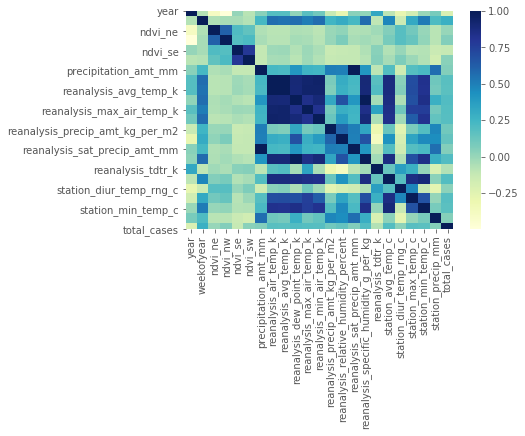

In [44]:
plt.style.use('ggplot')
sns.heatmap(sjcorr,cmap='YlGnBu')
plt.show()

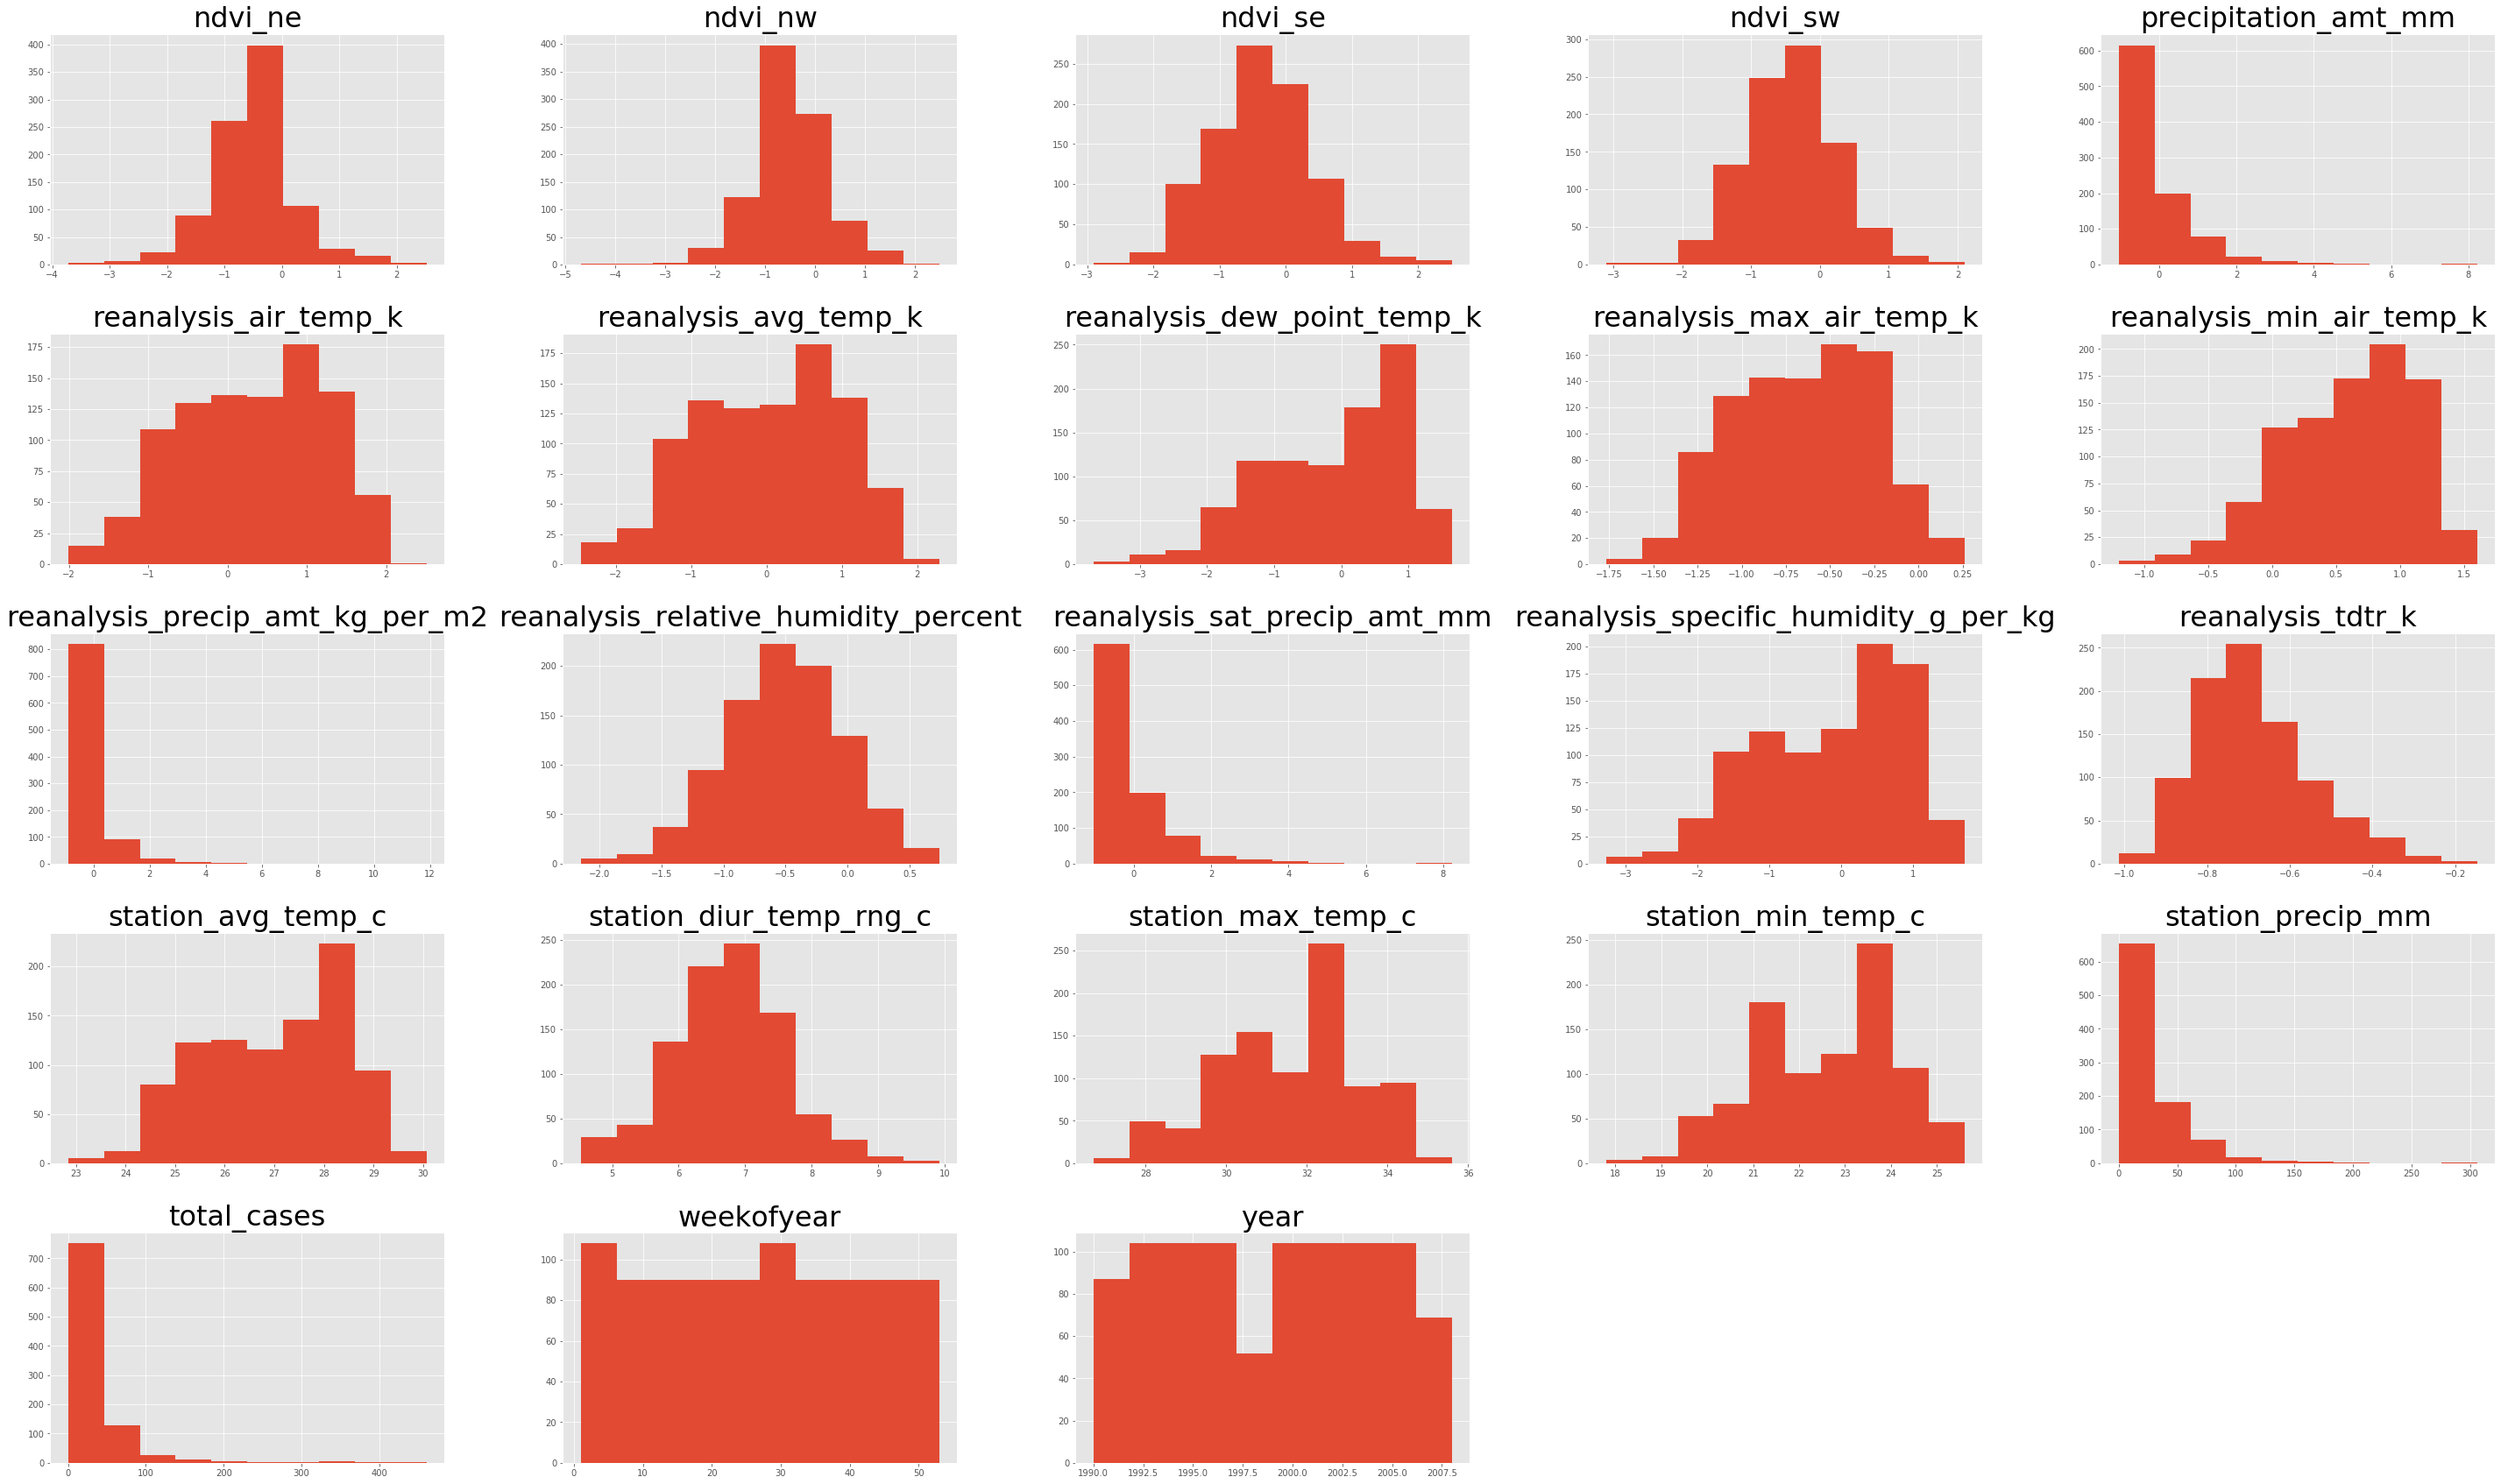

In [43]:
fig = sj_train_data.hist(figsize=(50,30))
[x.title.set_size(32) for x in fig.ravel()]
plt.show()

# Correlations from iquitos only (train data)

In [17]:
iq_train_data = all_data[(all_data['city']=='iq')& (all_data['set_type'] == 'train')]

iqcorr = iq_train_data.corr()

cmap = sns.diverging_palette(5, 250, as_cmap=True)

iqcorr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
year,1,-0.14,-0.061,0.034,-0.069,-0.013,0.087,0.026,0.008,0.32,-0.16,0.22,0.16,0.25,0.087,0.32,-0.24,0.081,-0.12,0.014,0.13,-0.035,0.18
weekofyear,-0.14,1,0.26,0.23,0.33,0.26,-0.1,0.29,0.3,-0.093,0.4,-0.026,-0.15,-0.28,-0.1,-0.083,0.35,0.084,0.22,0.19,-0.094,-0.045,-0.012
ndvi_ne,-0.061,0.26,1,0.76,0.77,0.84,-0.0086,0.15,0.17,-0.032,0.22,-0.0049,-0.084,-0.14,-0.0086,-0.031,0.17,0.12,0.15,0.14,-0.0078,0.011,0.02
ndvi_nw,0.034,0.23,0.76,1,0.65,0.77,-0.055,0.15,0.17,-0.033,0.2,0.0048,-0.077,-0.13,-0.055,-0.029,0.17,0.12,0.19,0.15,-0.09,-0.016,-0.011
ndvi_se,-0.069,0.33,0.77,0.65,1,0.71,-0.038,0.2,0.21,-0.061,0.26,-0.023,-0.12,-0.19,-0.038,-0.059,0.22,0.13,0.17,0.16,-0.051,0.012,-0.041
ndvi_sw,-0.013,0.26,0.84,0.77,0.71,1,-0.016,0.16,0.18,-0.03,0.23,-0.00024,-0.063,-0.14,-0.016,-0.027,0.17,0.12,0.17,0.17,-0.055,-0.0045,0.031
precipitation_amt_mm,0.087,-0.1,-0.0086,-0.055,-0.038,-0.016,1,-0.048,-0.054,0.47,-0.23,0.33,0.34,0.43,1,0.47,-0.38,0.13,-0.16,-0.0015,0.31,0.37,0.089
reanalysis_air_temp_k,0.026,0.29,0.15,0.15,0.2,0.16,-0.048,1,0.97,0.15,0.75,0.41,-0.087,-0.55,-0.048,0.18,0.55,0.59,0.51,0.65,0.24,-0.14,0.097
reanalysis_avg_temp_k,0.008,0.3,0.17,0.17,0.21,0.18,-0.054,0.97,1,0.14,0.78,0.39,-0.11,-0.54,-0.054,0.17,0.6,0.56,0.5,0.62,0.21,-0.14,0.08
reanalysis_dew_point_temp_k,0.32,-0.093,-0.032,-0.033,-0.061,-0.03,0.47,0.15,0.14,1,-0.26,0.76,0.57,0.74,0.47,1,-0.61,0.34,-0.23,0.095,0.62,0.18,0.23


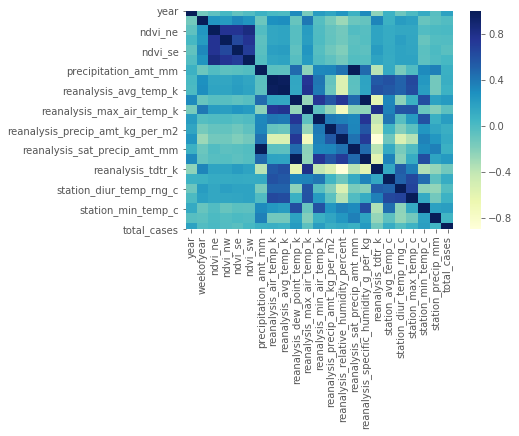

In [42]:
sns.heatmap(iqcorr, cmap="YlGnBu")
plt.show()

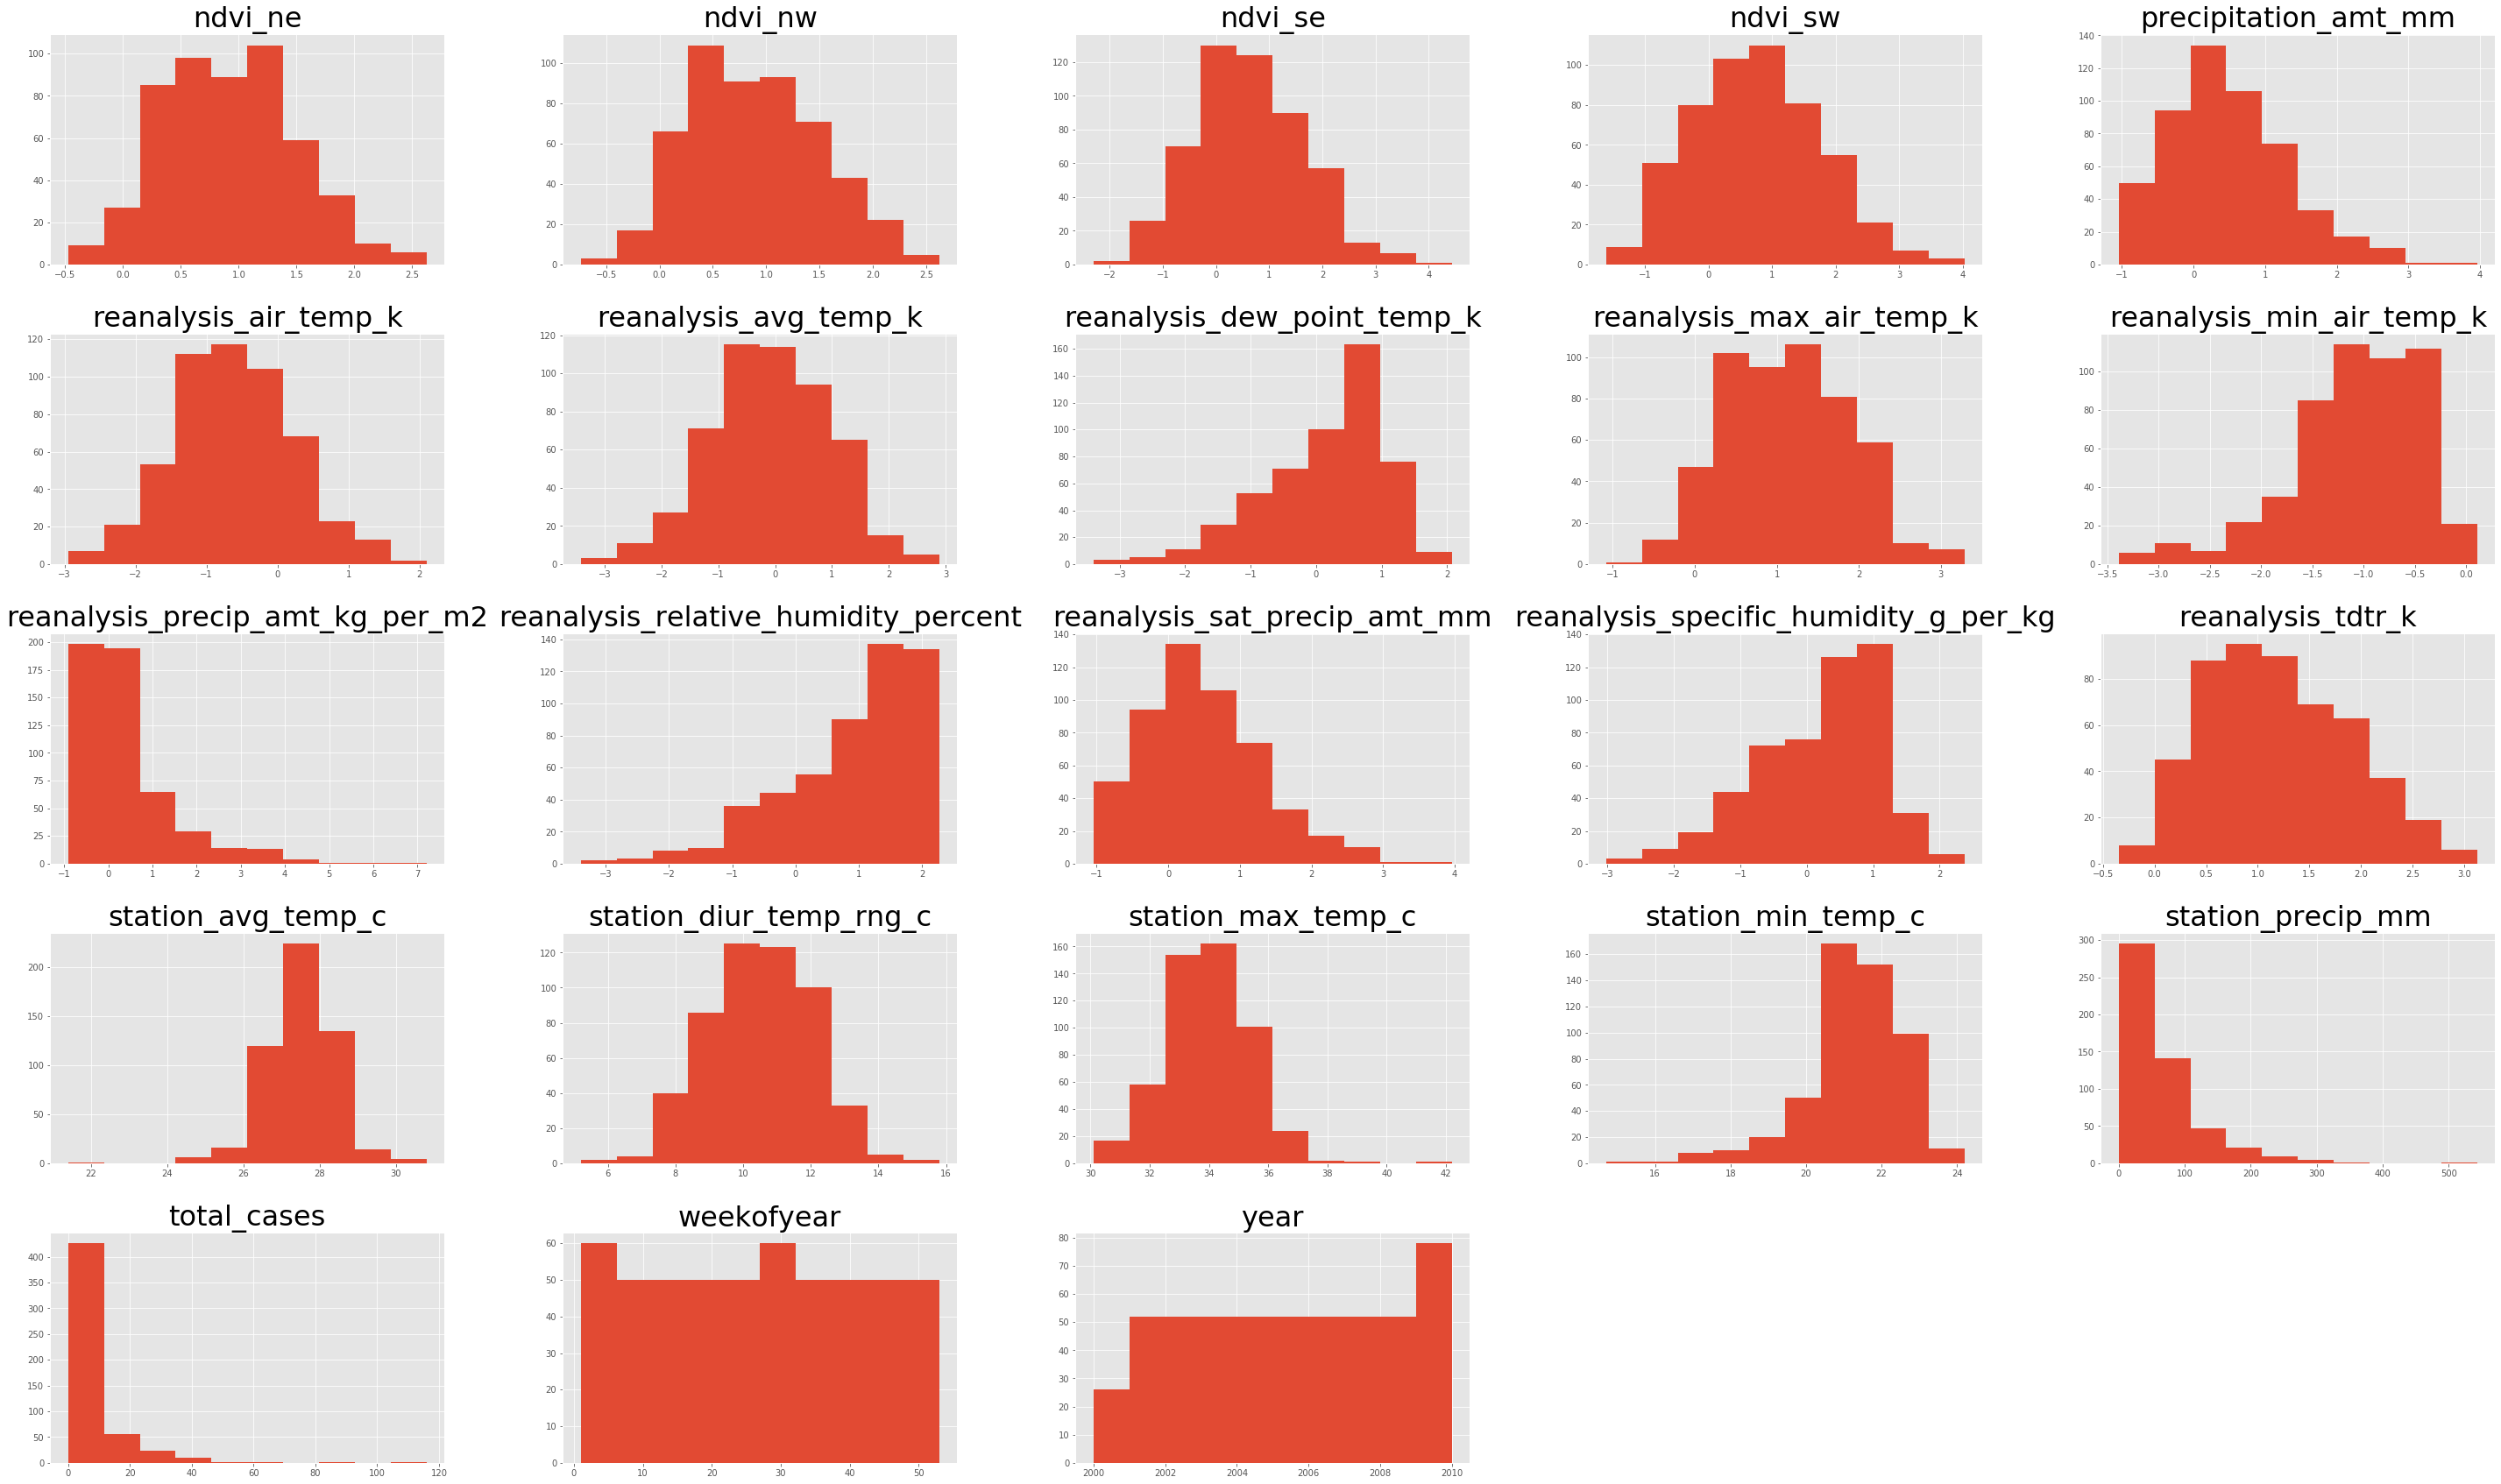

In [41]:
fig = iq_train_data.hist(figsize=(50,30))
[x.title.set_size(32) for x in fig.ravel()]
plt.show()

## Seeing here total cases, there doesn't seem to be any strong corelations in the data.

## Both iquitos and san juan have highest corelation in reanalysis_specific_humidity_g_per_kg

#### This makes sense since mosquitos tend to reproduce on water

In [56]:
all_train_data.columns

Index(['city', 'year', 'weekofyear', 'week_start_date', 'ndvi_ne', 'ndvi_nw',
       'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm', 'total_cases', 'set_type'],
      dtype='object')

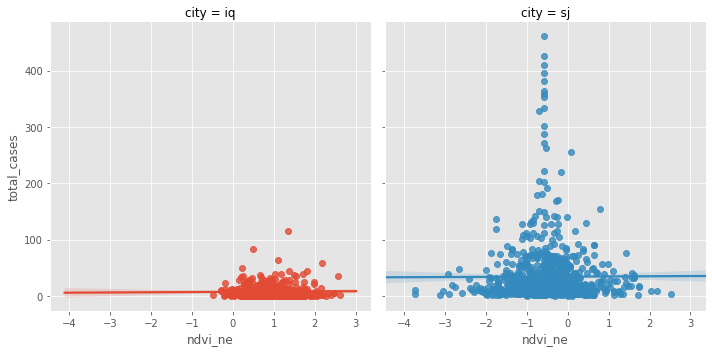

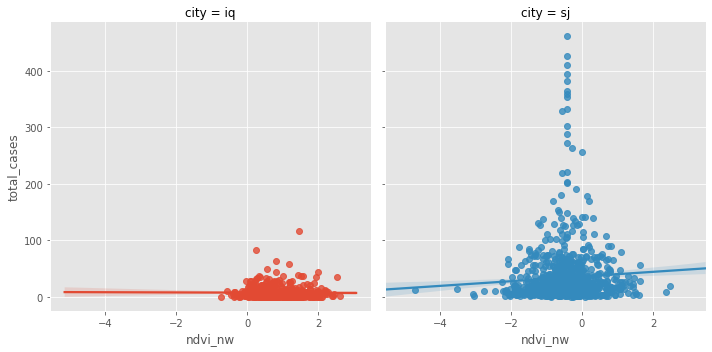

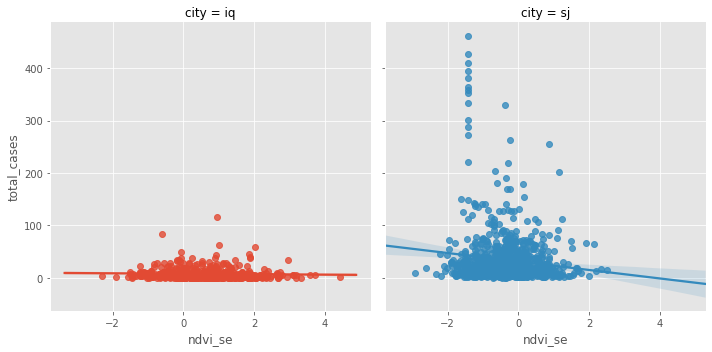

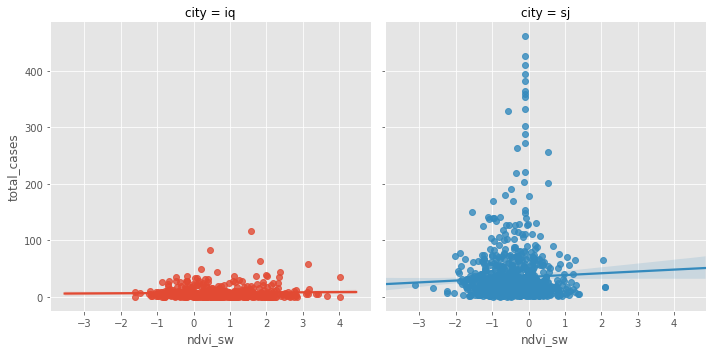

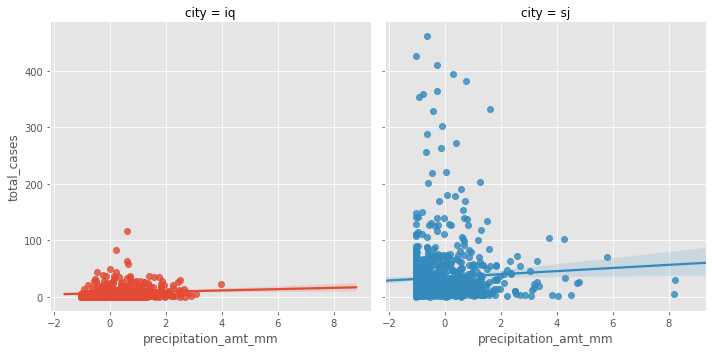

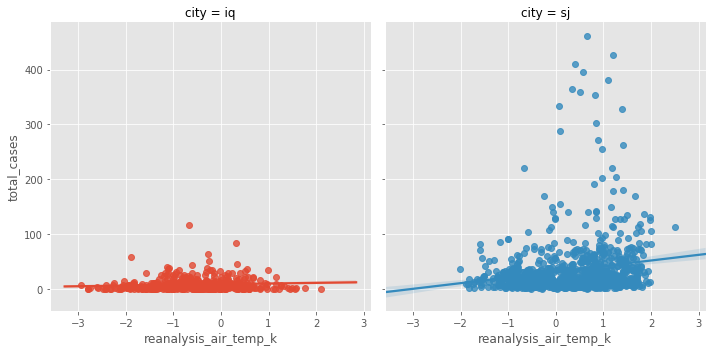

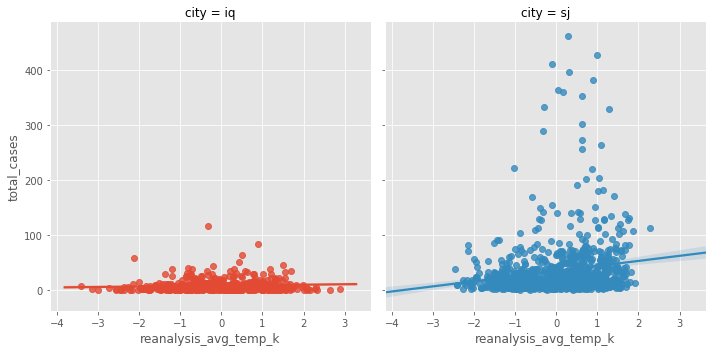

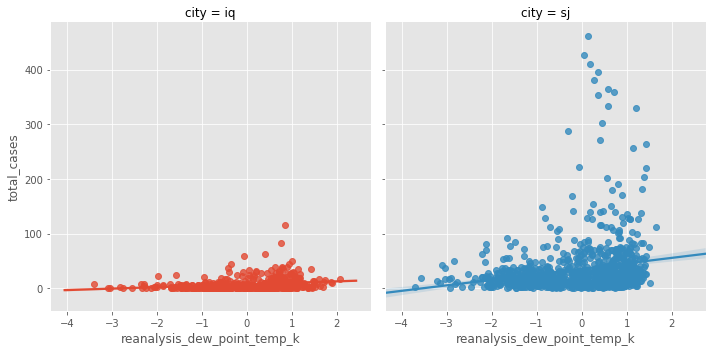

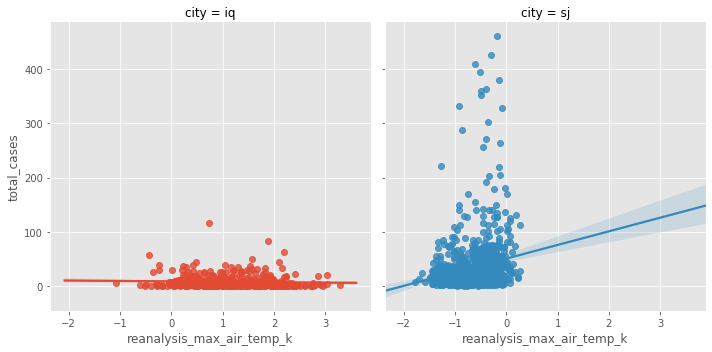

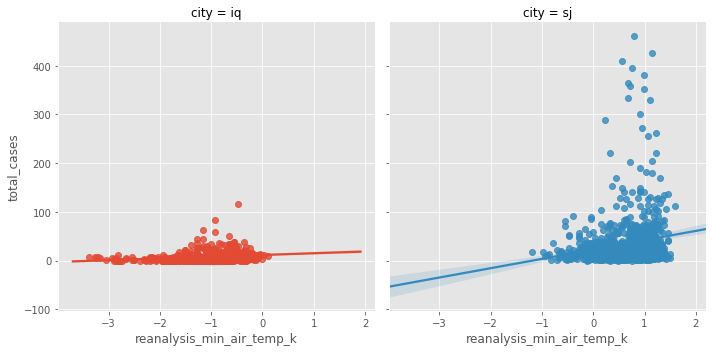

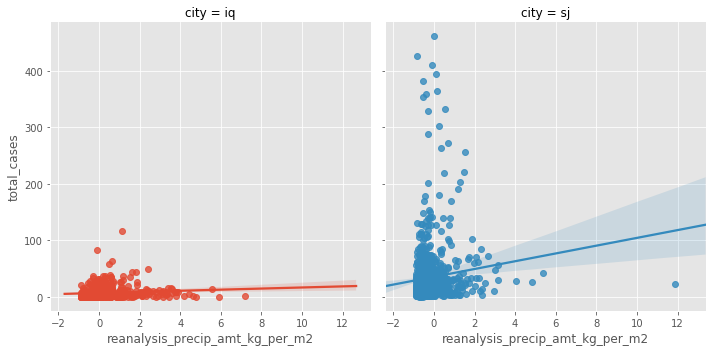

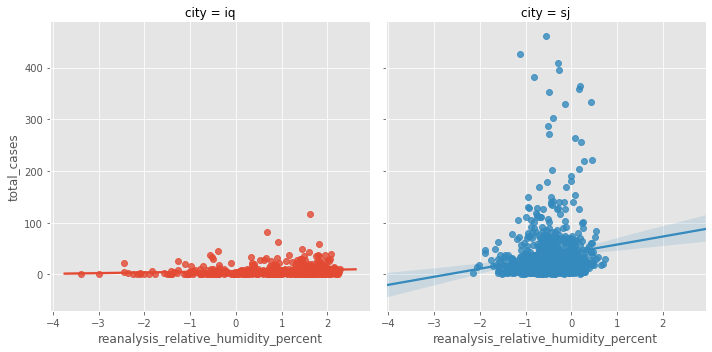

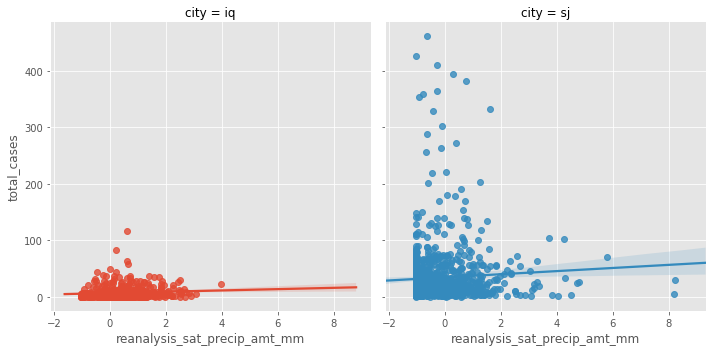

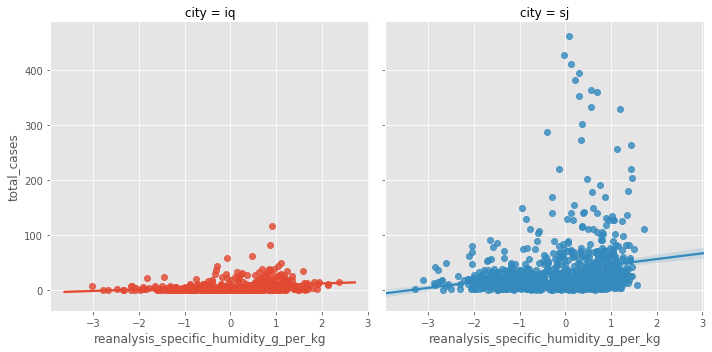

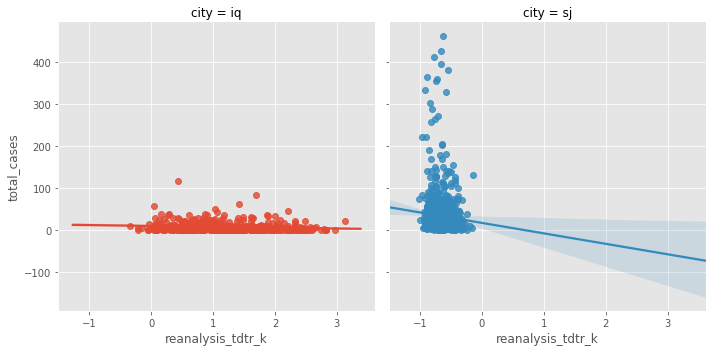

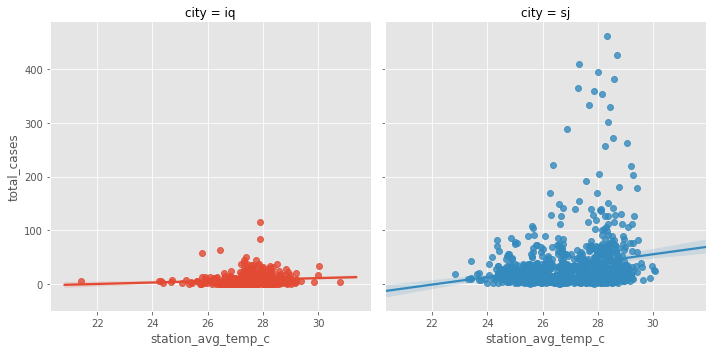

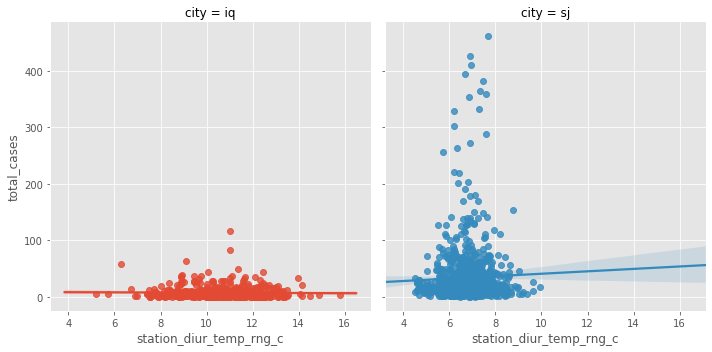

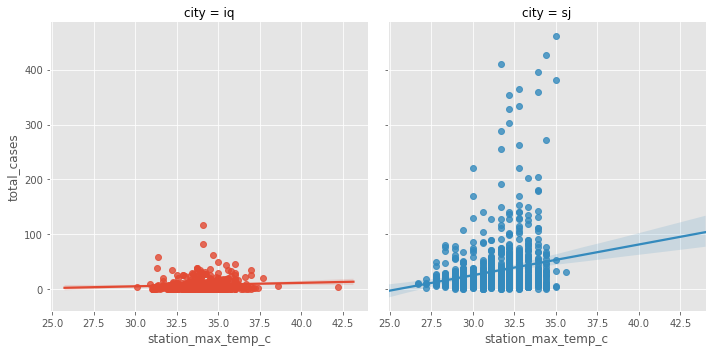

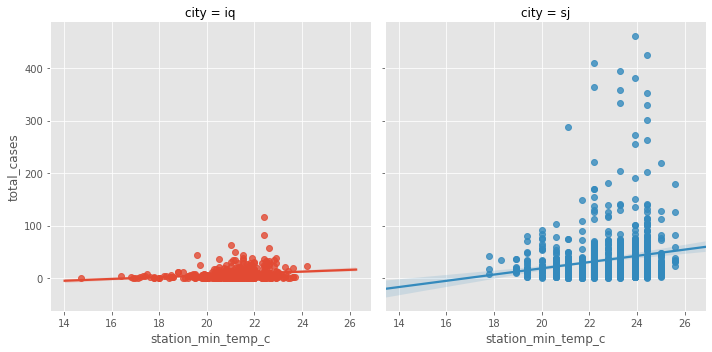

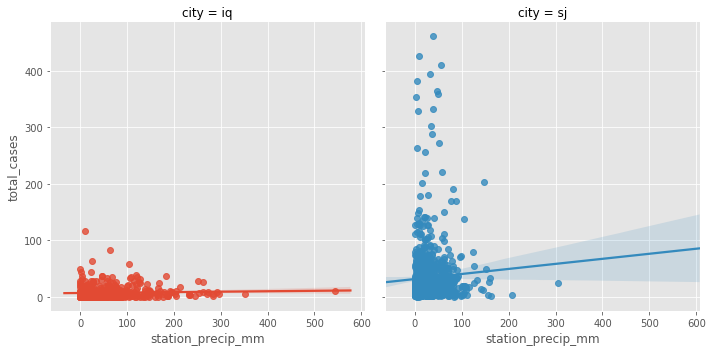

In [58]:
all_train_data = all_data[all_data['set_type'] == 'train']

#Grabbing only the numerical columns to iterate
colums_to_iter = all_train_data.columns[4:-2].values

#graphing a regression for all the data in both cities
for col in colums_to_iter:
    sns.lmplot(col,'total_cases',hue='city',col='city',
               data = all_train_data)    
    plt.show()

# Here one can see that San Juan has a higher corelation with the dataset (partly because it has more data to use).

In [ ]:
X = all_train[['ndvi_ne','ndvi_nw','ndvi_se','ndvi_sw','precipitation_amt_mm', 
                          'reanalysis_air_temp_k', 'reanalysis_avg_temp_k',
                         'reanalysis_dew_point_temp_k','reanalysis_max_air_temp_k',
                         'reanalysis_min_air_temp_k','reanalysis_precip_amt_kg_per_m2',
                         'reanalysis_sat_precip_amt_mm',
                         'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
                         'station_avg_temp_c','station_diur_temp_rng_c', 'station_max_temp_c',
                         'station_min_temp_c','station_precip_mm','city_iq','city_sj']].values
y=all_train[['total_cases']].values

In [ ]:
X

In [ ]:
sns.regplot(y='total_cases',x='reanalysis_min_air_temp_k',data=all_train)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

In [ ]:
regressor = LinearRegression(n_jobs=15)
regressor.fit(X_train,y_train)

In [ ]:
y_pred= regressor.predict(X_test)
y_pred

In [ ]:
regressor.score(X_test,y_test)

In [ ]:
print(regressor.intercept_)

In [ ]:
print(regressor.coef_)

In [ ]:
r2_score(y_test,y_pred)

In [ ]:
X_train

In [ ]:
plt.scatter(X_test[:,10], y_test, color='red')
#plt.plot(X_train[:,10], regressor.predict(X_train[:,10]), color='blue')
plt.title('Training set')
plt.xlabel('X')
plt.ylabel('y')
plt.show()

In [ ]:
knn_scores = []
for k in range(1,25):
    knn_test = KNeighborsClassifier(n_neighbors=k)
    knn_test.fit(X_train, y_train)
    knn_scores.append(knn_test.score(X_test, y_test))
    
plt.plot([k for k in range(1, 25)], knn_scores, color = 'red')
for i in range(1,25):
    plt.text(i, knn_scores[i-1], (i, knn_scores[i-1]))
plt.xticks([i for i in range(1, 25)])
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Scores')
plt.title('K Neighbors Classifier scores for different K values')
plt.show()

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
cross_val_score(knn,X,y,cv=10,scoring='accuracy').mean()

In [ ]:
logreg=LogisticRegression()
cross_val_score(logreg,X,y,cv=20,scoring='accuracy').mean()

With this i can conclude that the best (at the moment) model to train my algorithm is linear regression

In [ ]:
Test_set.head()

In [ ]:
prediction = regressor.predict()